# Synchronous Federated Learning

In [1]:
%matplotlib inline

import sys
import os
helpers_path = os.path.abspath('../')
if helpers_path not in sys.path:
    sys.path.append(helpers_path)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import Kernel

from data.datasets import load_dodd

from online_kernels.klms import KLMS
from online_kernels.knlms import KNLMS
from online_kernels.krls import KRLS
from online_kernels.klmsRFF import klms_rff
from online_kernels.knlmsRFF import knlms_rff
from online_kernels.krlsRFF import krls_rff

from federatedLearning import fl_sync, cent_learn

# Multiprocessing
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [2]:
num_data = 3000
kernel = Kernel(3.73)

step_size = 0.8
reg_coeff = 1e-6

K = 10 # K edge clients
c = np.ones(K).reshape(K,1)/K # edge weighting
D = 100 # Dictionary size
L = [100]
iteration = 10000
num_experiments = 10

KLMS_RFF = klms_rff(step_size,D)
KNLMS_RFF = knlms_rff(step_size,reg_coeff,D)
KRLS_RFF = krls_rff(D,beta=0.01,l=1.0)
KLMS_RFF_cent = klms_rff(0.1,D)
KNLMS_RFF_cent = knlms_rff(0.1,1e-8,D)
KRLS_RFF_cent = krls_rff(D,beta=4,l=1.0)

In [3]:
# KLMS
L = [20, 100, 150]

amse_KLMS = []
for l in L:
    amse_epoch = np.zeros(iteration)
    amse_cent = np.zeros(iteration)
    for epoch in tqdm(range(num_experiments)):

        # Process data and kernel
        u,d,d_true = load_dodd(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(2,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        FLsync = fl_sync(K,h,l)
        
        # Federated learning
        mse_cent = cent_learn(iteration,K,KLMS_RFF_cent,h,u,d)
        amse_cent += mse_cent/num_experiments
        mse = FLsync.train(iteration,KLMS_RFF,u,d)
        amse_epoch += mse/num_experiments
    amse_KLMS.append(amse_epoch)

100%|███████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


In [4]:
# KNLMS
L = [20, 100, 150]

amse_KNLMS = []
for l in L:
    amse_epoch = np.zeros(iteration)
    amse_cent = np.zeros(iteration)
    for epoch in tqdm(range(num_experiments)):

        # Process data and kernel
        u,d,d_true = load_dodd(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(2,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        FLsync = fl_sync(K,h,l)
        
        # Federated learning
        mse_cent = cent_learn(iteration,K,KNLMS_RFF_cent,h,u,d)
        amse_cent += mse_cent/num_experiments
        mse = FLsync.train(iteration,KNLMS_RFF,u,d)
        amse_epoch += mse/num_experiments
    amse_KNLMS.append(amse_epoch)

100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.15s/it]


In [5]:
# KRLS
L = [20, 100, 150]

step_size = 0.8
KRLS_RFF = krls_rff(D,beta=0.01,l=1.0)
KRLS_RFF_cent = krls_rff(D,beta=4,l=1.0)
amse_KRLS = []
for l in L:
    amse_epoch = np.zeros(iteration)
    amse_cent = np.zeros(iteration)
    for epoch in tqdm(range(num_experiments)):

        # Process data and kernel
        u,d,d_true = load_dodd(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(2,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        FLsync = fl_sync(K,h,l)
        
        # Federated learning
        mse_cent = cent_learn(iteration,K,KRLS_RFF_cent,h,u,d)
        amse_cent += mse_cent/num_experiments
        mse = FLsync.train(iteration,KRLS_RFF,u,d)
        amse_epoch += mse/num_experiments
    amse_KRLS.append(amse_epoch)

100%|███████████████████████████████████████████| 10/10 [00:35<00:00,  3.55s/it]


Text(0.5, 0, 'iteration')

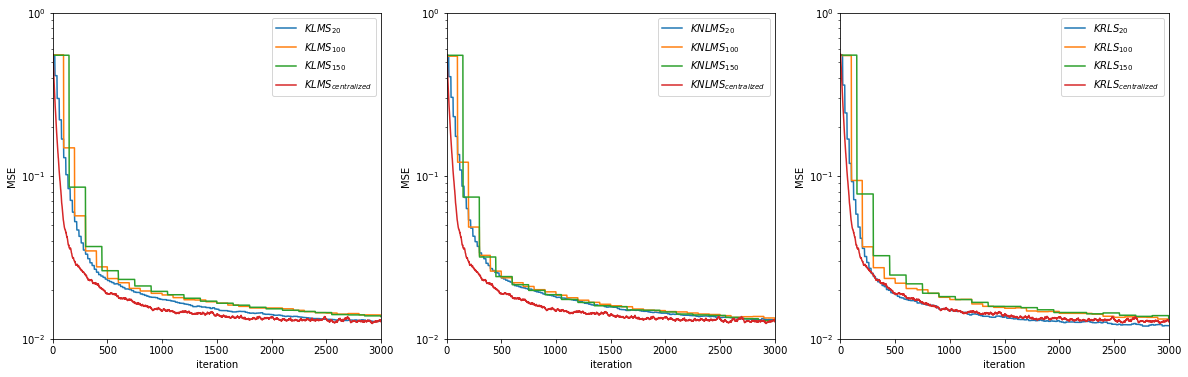

In [7]:
plt.figure(figsize=(2*10, 6))
plt.subplot(1,3,1)
for i in range(len(amse_KLMS)):
    plt.semilogy(range(len(amse_KLMS[i])),amse_KLMS[i],label="$KLMS_{" + str(L[i])+"}$")
plt.semilogy(range(len(amse_cent)),amse_cent,label="$KLMS_{centralized}$")
plt.legend()
plt.ylim([1e-2,1e0])
plt.xlim([0,3000])
plt.ylabel("MSE")
plt.xlabel("iteration")
plt.subplot(1,3,2)
for i in range(len(amse_KNLMS)):
    plt.semilogy(range(len(amse_KNLMS[i])),amse_KNLMS[i],label="$KNLMS_{" + str(L[i])+"}$")
plt.semilogy(range(len(amse_cent)),amse_cent,label="$KNLMS_{centralized}$")
plt.legend()
plt.ylim([1e-2,1e0])
plt.xlim([0,3000])
plt.ylabel("MSE")
plt.xlabel("iteration")
plt.subplot(1,3,3)
for i in range(len(amse_KRLS)):
    plt.semilogy(range(len(amse_KRLS[i])),amse_KRLS[i],label="$KRLS_{" + str(L[i])+"}$")
plt.semilogy(range(len(amse_cent)),amse_cent,label="$KRLS_{centralized}$")
plt.legend()
plt.ylim([1e-2,1e0])
plt.xlim([0,3000])
plt.ylabel("MSE")
plt.xlabel("iteration")

100%|███████████████████████████████████████████| 10/10 [00:38<00:00,  3.87s/it]


Text(0.5, 0, 'iteration')

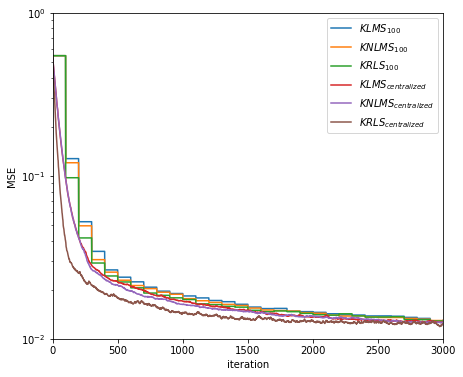

In [8]:
# Synchronous Federated learning using different kernels

plt.figure(figsize=(7, 6))
for l in L:
    amse_KLMS = np.zeros(iteration)
    amse_KNLMS = np.zeros(iteration)  
    amse_KRLS = np.zeros(iteration)  
    amse_KLMS_cent = np.zeros(iteration)
    amse_KNLMS_cent = np.zeros(iteration)  
    amse_KRLS_cent = np.zeros(iteration)    

    for epoch in tqdm(range(num_experiments)):

        # Process data and kernel
        u,d,d_true = load_dodd(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(2,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        FLsync = fl_sync(K,h,l)
        
        mse_KLMS_cent = cent_learn(iteration,K,KLMS_RFF_cent,h,u,d)
        amse_KLMS_cent += mse_KLMS_cent/num_experiments
        mse_KNLMS_cent = cent_learn(iteration,K,KNLMS_RFF_cent,h,u,d)
        amse_KNLMS_cent += mse_KNLMS_cent/num_experiments
        mse_KRLS_cent = cent_learn(iteration,K,KRLS_RFF_cent,h,u,d)
        amse_KRLS_cent += mse_KRLS_cent/num_experiments
        
        mse_KLMS = FLsync.train(iteration,KLMS_RFF,u,d)
        amse_KLMS += mse_KLMS/num_experiments
        mse_KNLMS = FLsync.train(iteration,KNLMS_RFF,u,d)
        amse_KNLMS += mse_KNLMS/num_experiments
        mse_KRLS = FLsync.train(iteration,KRLS_RFF,u,d)
        amse_KRLS += mse_KRLS/num_experiments  
        
plt.semilogy(range(len(amse_KLMS)),amse_KLMS,label="$KLMS_{" + str(l)+"}$")
plt.semilogy(range(len(amse_KNLMS)),amse_KNLMS,label="$KNLMS_{" + str(l)+"}$")
plt.semilogy(range(len(amse_KRLS)),amse_KRLS,label="$KRLS_{" + str(l)+"}$")
plt.semilogy(range(len(amse_KLMS_cent)),amse_KLMS_cent,label="$KLMS_{centralized}$")
plt.semilogy(range(len(amse_KNLMS_cent)),amse_KNLMS_cent,label="$KNLMS_{centralized}$")
plt.semilogy(range(len(amse_KRLS_cent)),amse_KRLS_cent,label="$KRLS_{centralized}$")
plt.legend()
plt.ylim([1e-2,1e0])
plt.xlim([0,3000])
plt.ylabel("MSE")
plt.xlabel("iteration")

Text(0.5, 0, 'iteration')

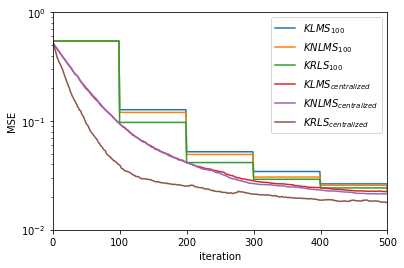

In [9]:
plt.semilogy(range(len(amse_KLMS)),amse_KLMS,label="$KLMS_{" + str(l)+"}$")
plt.semilogy(range(len(amse_KNLMS)),amse_KNLMS,label="$KNLMS_{" + str(l)+"}$")
plt.semilogy(range(len(amse_KRLS)),amse_KRLS,label="$KRLS_{" + str(l)+"}$")
plt.semilogy(range(len(amse_KLMS_cent)),amse_KLMS_cent,label="$KLMS_{centralized}$")
plt.semilogy(range(len(amse_KNLMS_cent)),amse_KNLMS_cent,label="$KNLMS_{centralized}$")
plt.semilogy(range(len(amse_KRLS_cent)),amse_KRLS_cent,label="$KRLS_{centralized}$")
plt.legend()
plt.ylim([1e-2,1e0])
plt.xlim([0,500])
plt.ylabel("MSE")
plt.xlabel("iteration")

## Impact of Dictionary sizes

In [24]:
# KLMS
D = [50, 100, 150]
l = 100
amse_KLMS = []
amse_KLMS_cent = np.zeros(iteration)
for i in range(len(D)):
    KLMS_RFF = klms_rff(step_size,D[i])
    KLMS_RFF_cent = klms_rff(0.1,D[i])
    amse_epoch = np.zeros(iteration)

    for epoch in tqdm(range(num_experiments)):

        # Process data and kernel
        u,d,d_true = load_dodd(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(2,D[i]))
        b = np.random.uniform(0,2*np.pi,(D[i],1))
        h = np.sqrt(2/D[i]) * np.cos(W.T @ u.T + b)

        FLsync = fl_sync(K,h,l)
        
        # Federated learning
        if i == 0:
            mse_cent = cent_learn(iteration,K,KLMS_RFF_cent,h,u,d)
            amse_KLMS_cent += mse_cent/num_experiments
        mse = FLsync.train(iteration,KLMS_RFF,u,d)
        amse_epoch += mse/num_experiments
    amse_KLMS.append(amse_epoch)

100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.09it/s]


In [25]:
# KNLMS
D = [50, 100, 150]
l = 100
amse_KNLMS = []
amse_KNLMS_cent = np.zeros(iteration)
for i in D:
    KNLMS_RFF = knlms_rff(step_size,reg_coeff,D[i])
    KNLMS_RFF_cent = knlms_rff(0.1,1e-8,D[i])

    amse_epoch = np.zeros(iteration)

    for epoch in tqdm(range(num_experiments)):

        # Process data and kernel
        u,d,d_true = load_dodd(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(2,D[i]))
        b = np.random.uniform(0,2*np.pi,(D[i],1))
        h = np.sqrt(2/D[i]) * np.cos(W.T @ u.T + b)

        FLsync = fl_sync(K,h,l)
        
        # Federated learning
        if i==0:
            mse_cent = cent_learn(iteration,K,KNLMS_RFF_cent,h,u,d)
            amse_KNLMS_cent += mse_cent/num_experiments
        mse = FLsync.train(iteration,KNLMS_RFF,u,d)
        amse_epoch += mse/num_experiments
    amse_KNLMS.append(amse_epoch)

IndexError: list index out of range

In [ ]:
# KRLS
D = [50, 100, 150]
l = 100
step_size = 0.8
amse_KRLS = []
amse_KRLS_cent = np.zeros(iteration)
for i in D:
    KRLS_RFF = krls_rff(D[i],beta=0.01,l=1.0)
    KRLS_RFF_cent = krls_rff(D[i],beta=4,l=1.0)    
    amse_epoch = np.zeros(iteration)

    for epoch in tqdm(range(num_experiments)):

        # Process data and kernel
        u,d,d_true = load_dodd(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(2,D[i]))
        b = np.random.uniform(0,2*np.pi,(D[i],1))
        h = np.sqrt(2/D[i]) * np.cos(W.T @ u.T + b)

        FLsync = fl_sync(K,h,l)
        
        # Federated learning
        if i==0:
            mse_cent = cent_learn(iteration,K,KRLS_RFF_cent,h,u,d)
            amse_KRLS_cent += mse_cent/num_experiments
        mse = FLsync.train(iteration,KRLS_RFF,u,d)
        amse_epoch += mse/num_experiments
    amse_KRLS.append(amse_epoch)

Text(0.5, 0, 'iteration')

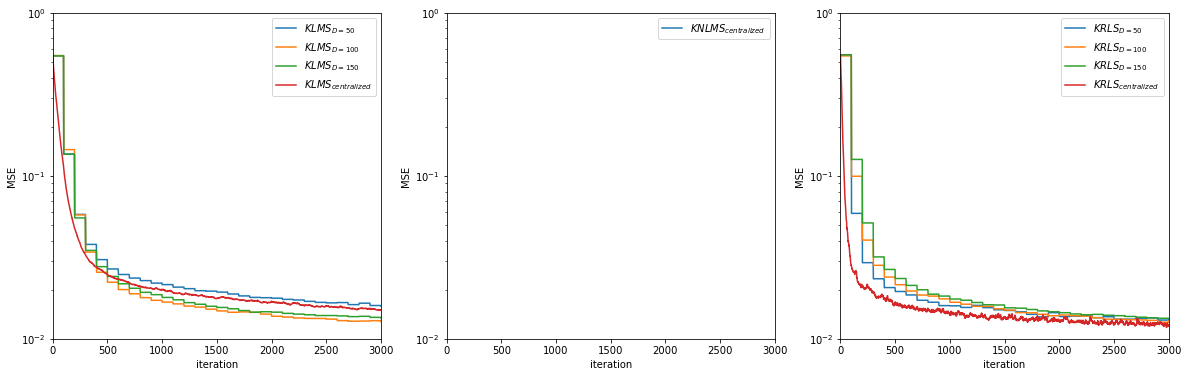

In [26]:
plt.figure(figsize=(2*10, 6))
plt.subplot(1,3,1)
for i in range(len(amse_KLMS)):
    plt.semilogy(range(len(amse_KLMS[i])),amse_KLMS[i],label="$KLMS_{D=" + str(D[i])+"}$")
plt.semilogy(range(len(amse_KLMS_cent)),amse_KLMS_cent,label="$KLMS_{centralized}$")
plt.legend()
plt.ylim([1e-2,1e0])
plt.xlim([0,3000])
plt.ylabel("MSE")
plt.xlabel("iteration")
plt.subplot(1,3,2)
for i in range(len(amse_KNLMS)):
    plt.semilogy(range(len(amse_KNLMS[i])),amse_KNLMS[i],label="$KNLMS_{D=" + str(D[i])+"}$")
plt.semilogy(range(len(amse_KNLMS_cent)),amse_KNLMS_cent,label="$KNLMS_{centralized}$")
plt.legend()
plt.ylim([1e-2,1e0])
plt.xlim([0,3000])
plt.ylabel("MSE")
plt.xlabel("iteration")
plt.subplot(1,3,3)
for i in range(len(amse_KRLS)):
    plt.semilogy(range(len(amse_KRLS[i])),amse_KRLS[i],label="$KRLS_{D=" + str(D[i])+"}$")
plt.semilogy(range(len(amse_KRLS_cent)),amse_KRLS_cent,label="$KRLS_{centralized}$")
plt.legend()
plt.ylim([1e-2,1e0])
plt.xlim([0,3000])
plt.ylabel("MSE")
plt.xlabel("iteration")

## Impace of Gaussian Widths

In [35]:
# KLMS
D = 100
l = 100
sigmas = [1.15,3.73,4.5]
amse_KLMS = []
amse_KLMS_cent = np.zeros(iteration)
for s in range(len(sigmas)):
    kernel = Kernel(sigmas[s])
    KLMS_RFF = klms_rff(step_size,D)
    KLMS_RFF_cent = klms_rff(0.1,D)
    amse_epoch = np.zeros(iteration)

    for epoch in tqdm(range(num_experiments)):

        # Process data and kernel
        u,d,d_true = load_dodd(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(2,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        FLsync = fl_sync(K,h,l)
        
        # Federated learning
        if s==1:
            mse_cent = cent_learn(iteration,K,KLMS_RFF_cent,h,u,d)
            amse_KLMS_cent += mse_cent/num_experiments
        mse = FLsync.train(iteration,KLMS_RFF,u,d)
        amse_epoch += mse/num_experiments
    amse_KLMS.append(amse_epoch)

100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.10it/s]


In [36]:
# KNLMS
D = 100
l = 100
sigmas = [1.15,3.73,4.5]
amse_KNLMS = []
amse_KNLMS_cent = np.zeros(iteration)
for s in range(len(sigmas)):
    kernel = Kernel(sigmas[s])
    KNLMS_RFF = knlms_rff(step_size,reg_coeff,D)
    KNLMS_RFF_cent = knlms_rff(0.1,1e-8,D)

    amse_epoch = np.zeros(iteration)

    for epoch in tqdm(range(num_experiments)):

        # Process data and kernel
        u,d,d_true = load_dodd(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(2,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        FLsync = fl_sync(K,h,l)
        
        # Federated learning
        if s==1:
            mse_cent = cent_learn(iteration,K,KNLMS_RFF_cent,h,u,d)
            amse_KNLMS_cent += mse_cent/num_experiments
        mse = FLsync.train(iteration,KNLMS_RFF,u,d)
        amse_epoch += mse/num_experiments
    amse_KNLMS.append(amse_epoch)

100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.81it/s]


In [37]:
# KRLS
D = 100
l = 100
sigmas = [1.15,3.73,4.5]
amse_KRLS = []
amse_KRLS_cent = np.zeros(iteration)
for s in range(len(sigmas)):
    kernel = Kernel(sigmas[s])
    KRLS_RFF = krls_rff(D,beta=0.1,l=1.0)
    KRLS_RFF_cent = krls_rff(D,beta=3,l=1.0)    
    amse_epoch = np.zeros(iteration)

    for epoch in tqdm(range(num_experiments)):

        # Process data and kernel
        u,d,d_true = load_dodd(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(2,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        FLsync = fl_sync(K,h,l)
        
        # Federated learning
        if s ==1:
            mse_cent = cent_learn(iteration,K,KRLS_RFF_cent,h,u,d)
            amse_KRLS_cent += mse_cent/num_experiments
        mse = FLsync.train(iteration,KRLS_RFF,u,d)
        amse_epoch += mse/num_experiments
    amse_KRLS.append(amse_epoch)

100%|███████████████████████████████████████████| 10/10 [00:14<00:00,  1.50s/it]


Text(0.5, 0, 'iteration')

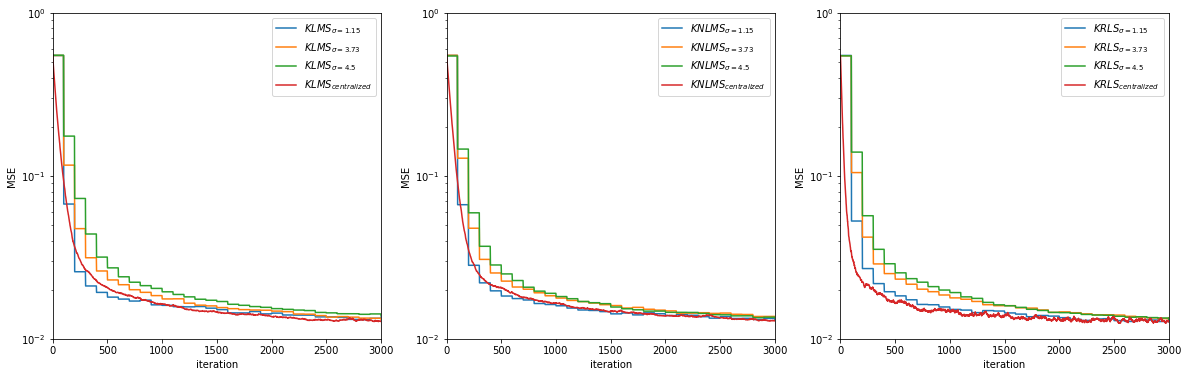

In [38]:
plt.figure(figsize=(2*10, 6))
plt.subplot(1,3,1)
for i in range(len(amse_KLMS)):
    plt.semilogy(range(len(amse_KLMS[i])),amse_KLMS[i],label="$KLMS_{\sigma=" + str(sigmas[i])+"}$")
plt.semilogy(range(len(amse_KLMS_cent)),amse_KLMS_cent,label="$KLMS_{centralized}$")
plt.legend()
plt.ylim([1e-2,1e0])
plt.xlim([0,3000])
plt.ylabel("MSE")
plt.xlabel("iteration")
plt.subplot(1,3,2)
for i in range(len(amse_KNLMS)):
    plt.semilogy(range(len(amse_KNLMS[i])),amse_KNLMS[i],label="$KNLMS_{\sigma=" + str(sigmas[i])+"}$")
plt.semilogy(range(len(amse_KNLMS_cent)),amse_KNLMS_cent,label="$KNLMS_{centralized}$")
plt.legend()
plt.ylim([1e-2,1e0])
plt.xlim([0,3000])
plt.ylabel("MSE")
plt.xlabel("iteration")
plt.subplot(1,3,3)
for i in range(len(amse_KRLS)):
    plt.semilogy(range(len(amse_KRLS[i])),amse_KRLS[i],label="$KRLS_{\sigma=" + str(sigmas[i])+"}$")
plt.semilogy(range(len(amse_KRLS_cent)),amse_KRLS_cent,label="$KRLS_{centralized}$")
plt.legend()
plt.ylim([1e-2,1e0])
plt.xlim([0,3000])
plt.ylabel("MSE")
plt.xlabel("iteration")